# Calcul des mappings - Introduction
Ce notebook sert à calculer un mapping entre deux graphes : il s'agit, pour chaque noeud du graphe A, d'associer un noeud du graphe B.

Ici, les noeuds possèdent un libellé. On calcule l'embedding d'un noeud comme la concaténation de l'embedding de son parent et celui de son libellé. L'embedding des libellé est calculé comme la moyenne des embeddings des mots, eux-mêmes tirés de Fast Text.

Au préalable, les données sont organisées dans `./parsing_pipeline.ipynb` selon le format suivant :
```
interface Node {
    name: string,
    children: Node[],
}
```

Commandes pour générer les fichiers `.csv` depuis le dump envoyé par la Direction du Budget :
```
ls | xargs -i basename {} .xlsx | xargs -i ssconvert {}.xlsx {}.csv
find -name '*.csv' | xargs -i wc -l {}
```

In [1]:
import csv
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook, tqdm

/home/alexis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
EMBEDDING_FILEPATH = '/home/alexis/mva/word_embeddings/wiki.fr.vec'

PLF_NOMENCLATURES_FOLDER = './raw_data/'
PLF_GRAPH_OUTPUT_FOLDER = '../server/resources/plf_all_nodes/'
VOTES_OUTPUT_FOLDER = '../server/resources/plf_votes/'
MAPPINGS_OUTPUT_FOLDER = '../server/resources/plf_mappings/'

WORD_EMBEDDING_SIZE = 300
K = 5

# Chargement des embeddings

Load FastText pretrained embeddings. These should be downloaded from `https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec`.

`EMBEDDING_FILE_PATH` should point to where this file is stored.

In [3]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILEPATH, binary=False)

# Mapping de nomenclatures

## Pipeline
Dans un premier temps, on calcule les embeddings de chacun des noeuds.
Pour cela, on parcourt l'arbre récursivement, en ajoutant chaque fois l'embedding
du noeud actuel à une liste.
L'embedding d'un noeud est pour moitié celui de son parent, pour moitié l'embedding
de son propre libellé. L'embedding du libellé est lui-même la moyenne des embedding
de chacun des mots du libellé.

In [154]:
def build_all_nodes_from_json(root_node):
    nodes = []

    def rec_build_embedding(node, parent_embedding, accPath):
        ## Split current node's name
        words = keras.preprocessing.text.text_to_word_sequence(
            node['name'],
            filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
            lower=True,
            split=' '
        )

        ## Initiate sentence embedding;
        ## Sentence embedding will be the average
        ## of all present word embeddings.
        sentence_embedding = np.zeros((1, WORD_EMBEDDING_SIZE))

        ## Create embedding for each word
        for word in words:
            try:
                sentence_embedding += pretrained_embeddings[word.lower()]
            except:
                # If word does not exist in pretrained embedding,
                # give it null embedding
                pass

        ## Normalize sentence embedding
        sentence_embedding /= max(len(words), 1)

        ## Concatenate embedding with parent node embedding
        node_embedding = np.concatenate((
            np.array(parent_embedding[0]).reshape((1, WORD_EMBEDDING_SIZE)) +
            np.array(parent_embedding[1]).reshape((1, WORD_EMBEDDING_SIZE)),
            sentence_embedding
        ))
        
        r = dict({
            'embedding': node_embedding
        })
        
        for key in node:
            if key != 'children':
                r[key] = node[key]
        
        r['libelles'] = accPath + [node['name']]

        nodes.append(r)
        
        if 'children' in node:
            for child in node['children']:
                rec_build_embedding(child, node_embedding, accPath + [node['name']])
    
    for node in root_node['children']:
        rec_build_embedding(node, np.zeros((2, WORD_EMBEDDING_SIZE)), [])

    return nodes

Une simple fonction pour effectuer un KNN avec scikit.

In [155]:
def find_nearest_neighbours(source_nodes, target_nodes, k=2):
    # Stack and flatten embeddings
    target_embeddings = np.array([node['embedding'].flatten() for node in target_nodes])
    source_embeddings = np.array([node['embedding'].flatten() for node in source_nodes])

    # Initiate scikit learn NearestNeighbors
    neighbours = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(target_embeddings)

    distances, indices = neighbours.kneighbors(source_embeddings)

    return distances, indices

Une simple fonction pour écrire les mappings générés dans un fichier json.
Ils sont triés par `key` : on récupère le code de chaque noeud, puis on écrit la liste
des noeuds suggérés (ici, on se tient à une liste de longueur 1).

In [156]:
def neighbours_to_json_file(source_nodes, target_nodes, indices, distances, output_filepath):
    mappings_dict = defaultdict(list)

    for source_index, (row_indices, row_distances) in enumerate(zip(indices, distances)):
        # Fill mappingsDict
        mappings_dict[source_nodes[source_index]['code']].append(dict({
            'distance': row_distances[0],
            'libelles': target_nodes[row_indices[0]]['libelles'],
            'code': target_nodes[row_indices[0]]['code']
        }))

    with open(output_filepath, 'w+') as f:
        json.dump(mappings_dict, f, default=lambda o: o.__dict__)

Quelques tests pour vérifier que le mapping s'est correctement passé.

In [157]:
def tests(distances):
    print('Percentage of not directly matched: {:.2f} % ({} / {})'.format(
        distances[distances[:,0] != 0].shape[0] / distances.shape[0] * 100,
        distances[distances[:,0] != 0].shape[0],
        distances.shape[0]
    ))
    
    print('Percentage of not uniquely matched: {:.2f} % ({} / {})'.format(
        len([1 for d in distances if (d[0] == 0 and d[1] == 0)]) / distances.shape[0] * 100,
        len([1 for d in distances if (d[0] == 0 and d[1] == 0)]),
        distances.shape[0]
    ))
    
    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 1, 1)
    ax.set_title('Distribution of distances of imperfectly matched nodes')
    n, bins, patches = ax.hist(distances[distances[:,0] != 0][:,0], 50)
    plt.show()

Enfin, une fonction qui exécute les blocks précédents.

In [158]:
def run_pipeline(source_tree_file, target_tree_file, output_filepath):
    # Load json files
    with open(source_tree_file, 'r') as source_file:
        source_root_node = json.load(source_file)
    source_nodes = build_all_nodes_from_json(source_root_node)

    with open(target_tree_file, 'r') as source_file:
        target_root_node = json.load(source_file)
    target_nodes = build_all_nodes_from_json(target_root_node)

    # Compute neighbours
    print('Compute KNN...')
    distances, indices = find_nearest_neighbours(source_nodes, target_nodes, k=K)

    # Output results
    neighbours_to_json_file(source_nodes, target_nodes, indices, distances, output_filepath)

    # Tests
    tests(distances)

## Tests

In [159]:
SOURCE_TREE_FILE = '../server/resources/recettes/2018.json'
TARGET_TREE_FILE = '../server/resources/recettes/2019.json'

In [160]:
with open(SOURCE_TREE_FILE, 'r') as source_file:
    source_root_node = json.load(source_file)

source_nodes = build_all_nodes_from_json(source_root_node)

with open(TARGET_TREE_FILE, 'r') as source_file:
    target_root_node = json.load(source_file)

target_nodes = build_all_nodes_from_json(target_root_node)

In [161]:
%%time
distances, indices = find_nearest_neighbours(source_nodes, target_nodes, k=K)

CPU times: user 70.9 ms, sys: 3.99 ms, total: 74.9 ms
Wall time: 71.7 ms


In [162]:
neighbours_to_json_file(source_nodes, target_nodes, indices, distances, '../server/resources/plf_mappings/recettes_2018_to_recettes_2019')

Percentage of not directly matched: 1.17 % (2 / 171)
Percentage of not uniquely matched: 0.00 % (0 / 171)


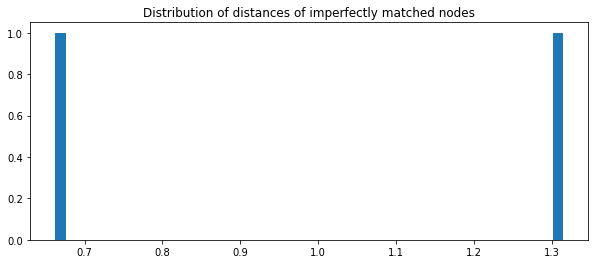

In [163]:
tests(distances)

## Création des mappings

In [164]:
INFO = {
    'PLF': {
        'tree_folder': './parsed_data',
        'to_folder': '../server/resources/mappings/plf'
    },
    'recettes': {
        'tree_folder': '../server/resources/recettes',
        'to_folder': '../server/resources/mappings/recettes'
    }
}

In [165]:
def compute_mapping(source_year, target_year, source_type):
    tree_folder = INFO[source_type]['tree_folder']
    to_folder = INFO[source_type]['to_folder']

    print('Compute {} to {}'.format(source_year, target_year))
    source_tree_file = os.path.join(tree_folder, '{}.json'.format(source_year))
    target_tree_file = os.path.join(tree_folder, '{}.json'.format(target_year))
    run_pipeline(source_tree_file, target_tree_file, os.path.join(to_folder, '{}_to_{}.json'.format(source_year, target_year)))
    print()

def compute_mappings(min_year, max_year, source_type, bothDirections=True):
    for year in range(min_year, max_year):
        compute_mapping(year, year+1, source_type)
        if bothDirections:
            compute_mapping(year+1, year, source_type)

### PLF

Compute 2012 to 2013
Compute KNN...
Percentage of not directly matched: 26.93 % (755 / 2804)
Percentage of not uniquely matched: 0.00 % (0 / 2804)


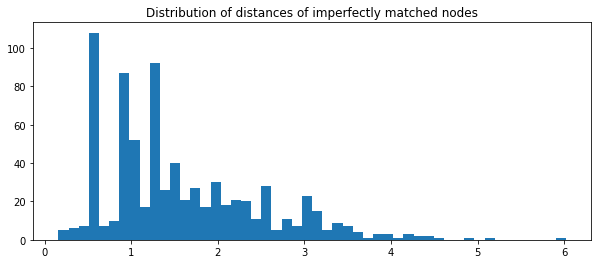


Compute 2013 to 2012
Compute KNN...
Percentage of not directly matched: 23.73 % (637 / 2684)
Percentage of not uniquely matched: 0.07 % (2 / 2684)


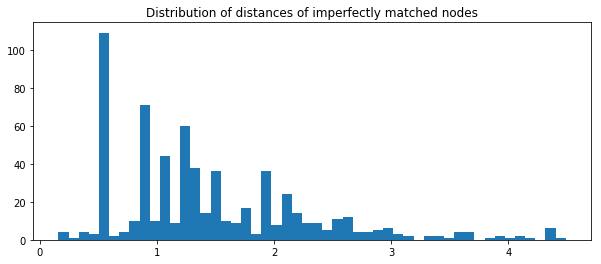


Compute 2013 to 2014
Compute KNN...
Percentage of not directly matched: 17.44 % (468 / 2684)
Percentage of not uniquely matched: 0.00 % (0 / 2684)


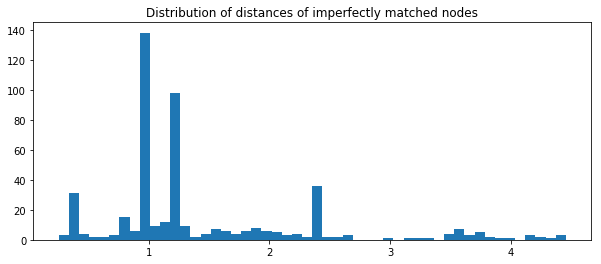


Compute 2014 to 2013
Compute KNN...
Percentage of not directly matched: 18.14 % (491 / 2707)
Percentage of not uniquely matched: 0.00 % (0 / 2707)


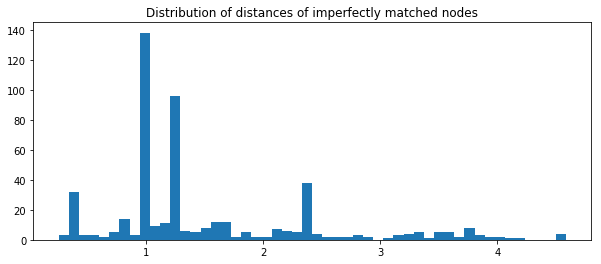


Compute 2014 to 2015
Compute KNN...
Percentage of not directly matched: 23.46 % (635 / 2707)
Percentage of not uniquely matched: 0.00 % (0 / 2707)


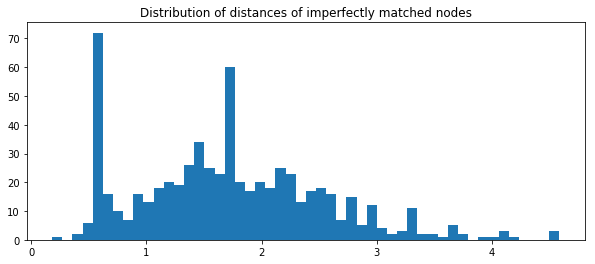


Compute 2015 to 2014
Compute KNN...
Percentage of not directly matched: 16.05 % (396 / 2468)
Percentage of not uniquely matched: 0.00 % (0 / 2468)


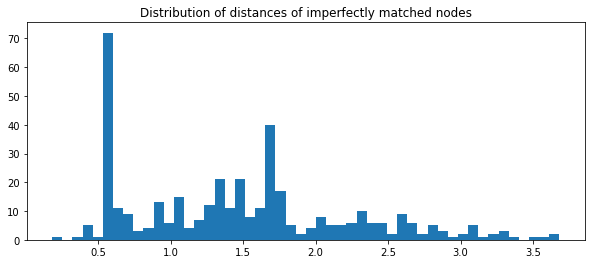


Compute 2015 to 2016
Compute KNN...
Percentage of not directly matched: 6.69 % (165 / 2468)
Percentage of not uniquely matched: 0.16 % (4 / 2468)


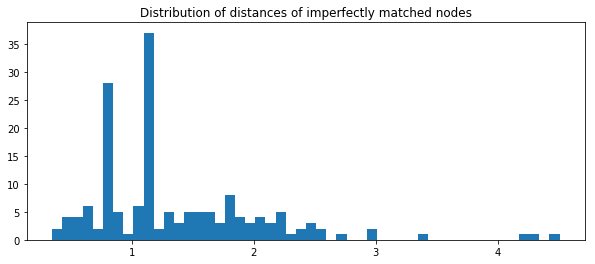


Compute 2016 to 2015
Compute KNN...
Percentage of not directly matched: 7.25 % (180 / 2483)
Percentage of not uniquely matched: 0.16 % (4 / 2483)


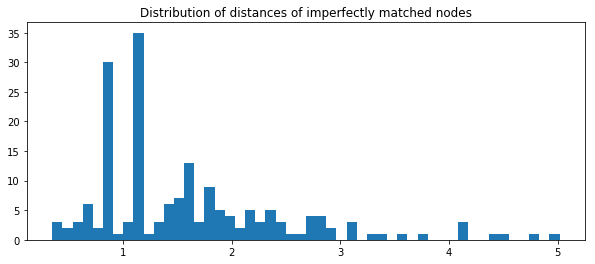


Compute 2016 to 2017
Compute KNN...
Percentage of not directly matched: 10.03 % (249 / 2483)
Percentage of not uniquely matched: 0.16 % (4 / 2483)


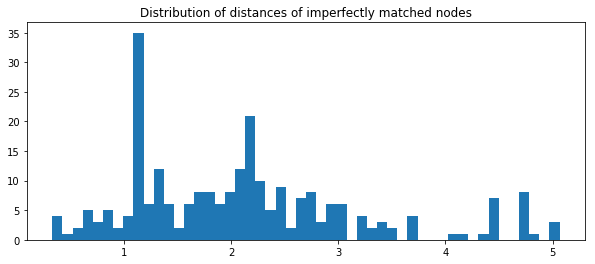


Compute 2017 to 2016
Compute KNN...
Percentage of not directly matched: 9.59 % (237 / 2471)
Percentage of not uniquely matched: 0.16 % (4 / 2471)


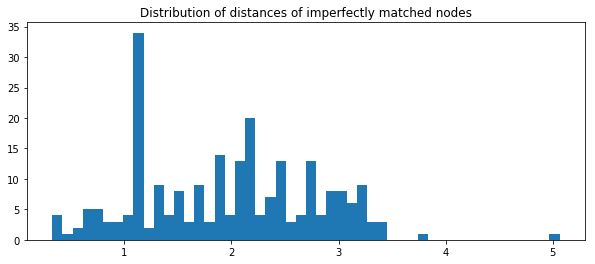


Compute 2017 to 2018
Compute KNN...
Percentage of not directly matched: 18.49 % (457 / 2471)
Percentage of not uniquely matched: 0.00 % (0 / 2471)


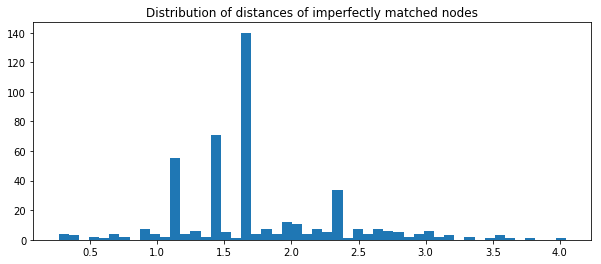


Compute 2018 to 2017
Compute KNN...
Percentage of not directly matched: 18.99 % (472 / 2486)
Percentage of not uniquely matched: 0.00 % (0 / 2486)


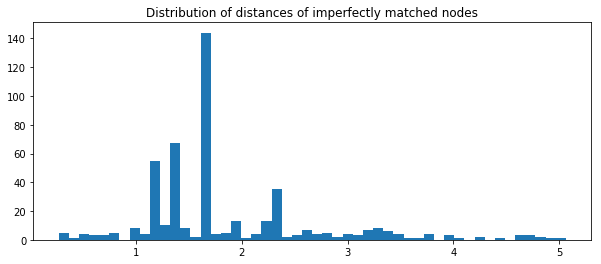


Compute 2018 to 2019
Compute KNN...
Percentage of not directly matched: 4.42 % (110 / 2486)
Percentage of not uniquely matched: 0.16 % (4 / 2486)


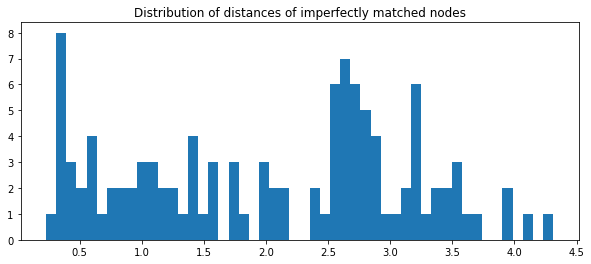


Compute 2019 to 2018
Compute KNN...
Percentage of not directly matched: 3.06 % (75 / 2451)
Percentage of not uniquely matched: 0.16 % (4 / 2451)


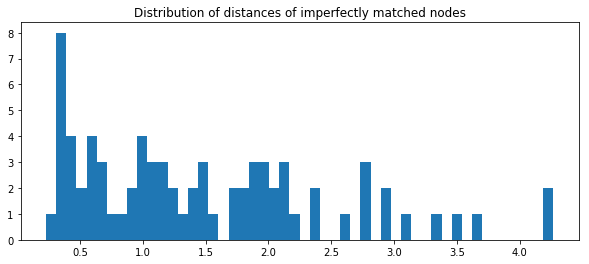

In [166]:
compute_mappings(2012, 2019, 'PLF')

### Recettes

Compute 2018 to 2019
Compute KNN...
Percentage of not directly matched: 1.17 % (2 / 171)
Percentage of not uniquely matched: 0.00 % (0 / 171)


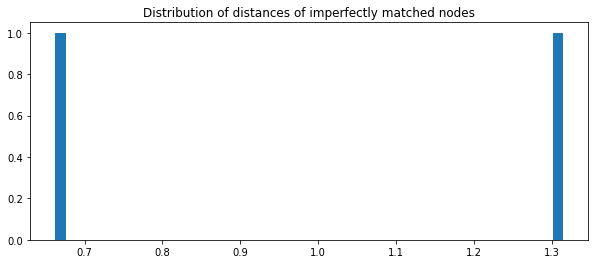


Compute 2019 to 2018
Compute KNN...
Percentage of not directly matched: 1.17 % (2 / 171)
Percentage of not uniquely matched: 0.00 % (0 / 171)


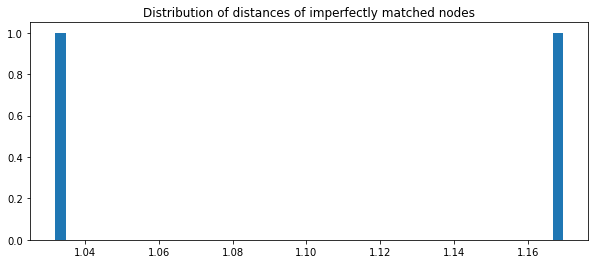

In [167]:
compute_mappings(2018, 2019, 'recettes')

Mon sacrifice est introduit daaaaans le volcan.